Lors de nos recherches on a cherché a accélérer le merge des relations ou entités, car plus le graphe était grand plus le merge prenait de temps (complexité exponentielle), l'objectif était de pre-catégoriser les entités de manières simples et très rapides. Finalement mrebel donne déjà une sous catégorie assez pertinante.

# How to categorize entities ?

## Bert

### FIRST EXAMPLE

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Load the pre-trained BERT model for sequence classification
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = BertTokenizer.from_pretrained(model_name)
print("Model Loaded")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loaded


In [ ]:
# ------------------------------------------------------
text = "Apple Inc. is planning to launch new products."
# ------------------------------------------------------

In [ ]:
tokens = tokenizer.encode_plus(text, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**tokens)


probas = torch.nn.functional.softmax(outputs.logits, dim=-1)
# print(probas)

predicted_class = torch.argmax(probas).item()
print("Predicted class:", predicted_class)

# Use the pipeline model for entity categorization
entity_classifier = pipeline("zero-shot-classification", model=model_name, device=device)
labels = ["Company", "Technology", "Political figure"]
result = entity_classifier(text, labels)

print(result)

Predicted class: 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'sequence': 'Apple Inc. is planning to launch new products.', 'labels': ['Political figure', 'Technology', 'Company'], 'scores': [0.403197318315506, 0.2999557554721832, 0.2968469262123108]}


### SECOND EXAMPLE

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default v

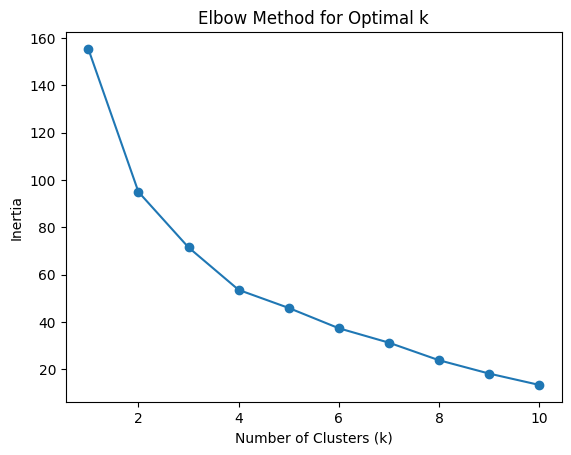

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Example words
words = ["Apple", "Samsung", "Car", "Table", "Economy", "Covid 19", "Jack Bogels", "Vanguard", "BlackRock", "Money", "Company", "Iphone", "Ipad", "Chair"]

# Encode the words
input_ids = tokenizer(words, return_tensors="pt", padding=True, truncation=True)["input_ids"]

# Get contextual embeddings
with torch.no_grad():
    outputs = model(input_ids)

# Extract the embeddings for the [CLS] token (representing the entire sequence)
embeddings = outputs.last_hidden_state[:, 0, :].numpy()

# Try different values of k
inertia_values = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


At 4-5 clusters there is a sharp decrease: 4 clusters needed

In [ ]:
from transformers import BertModel, BertTokenizer

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Example words
words = ["Apple", "Samsung", "Car", "Table", "Economy", "Covid 19", "Jack Bogels", "Vanguard", "BlackRock", "Money", "Company", "Iphone", "Ipad", "Chair"]

# Encode the words
input_ids = tokenizer(words, return_tensors="pt", padding=True, truncation=True)["input_ids"]

# Get contextual embeddings
with torch.no_grad():
    outputs = model(input_ids)

# Extract the embeddings for the [CLS] token (representing the entire sequence)
embeddings = outputs.last_hidden_state[:, 0, :]

# Now, you can use these embeddings for various downstream tasks, such as clustering or classification.

# For example, you can use k-means clustering to group words based on their embeddings
from sklearn.cluster import KMeans

# Number of clusters
num_clusters = 5

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings.numpy())

# Print the words and their assigned clusters
for word, cluster in zip(words, clusters):
    print(f"Word: {word}, Cluster: {cluster}")


Word: Apple, Cluster: 2
Word: Samsung, Cluster: 3
Word: Car, Cluster: 2
Word: Table, Cluster: 2
Word: Economy, Cluster: 2
Word: Covid 19, Cluster: 1
Word: Jack Bogels, Cluster: 4
Word: Vanguard, Cluster: 0
Word: BlackRock, Cluster: 2
Word: Money, Cluster: 2
Word: Company, Cluster: 0
Word: Iphone, Cluster: 3
Word: Ipad, Cluster: 3
Word: Chair, Cluster: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### THIRD EXAMPLE

In [ ]:
def categorize_word_bart(word):
    # Load the fine-tuned BART model for MNLI (MultiNLI) task
    model_name = "facebook/bart-large-mnli"
    classifier = pipeline("zero-shot-classification", model=model_name)

    # Specify the candidate labels/categories
    labels = ["person", "animal", "car", "food", "technology", "politics", "economy", "health", "other"]

    # Create a prompt by incorporating the word
    prompt = f"This is a {word}. Is it a {', '.join(labels)}?"

    # Perform zero-shot classification
    result = classifier(prompt, labels)

    # Extract the predicted category
    predicted_category = result['labels'][0]

    return predicted_category


word2 = "Elephant"
category2 = categorize_word_bart(word2)
print(f"Category for '{word2}': {category2}")

Category for 'Elephant': animal


### FOURTH EXAMPLE

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.cluster import KMeans

def categorize_words_distilbert(words):
    # Load the pre-trained DistilBERT model and tokenizer
    model_name = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name)

    # Encode the words
    input_ids = tokenizer(words, return_tensors="pt", padding=True, truncation=True)["input_ids"]

    # Move input to GPU if available
    input_ids = input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # Get the embeddings for the [CLS] token (representing the entire sequence)
    with torch.no_grad():
        outputs = model(input_ids)

    # Extract the embeddings for the [CLS] token
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Apply k-means clustering
    num_clusters = min(len(set(words)), 5)  # Choose the minimum between the number of unique words and 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)

    # Create a dictionary to store categories for each word
    word_categories = {}
    for word, cluster in zip(words, clusters):
        if cluster not in word_categories:
            word_categories[cluster] = [word]
        else:
            word_categories[cluster].append(word)

    return word_categories

# Example usage
words = ["Apple", "Samsung", "Car", "Table", "Economy", "Covid 19", "Jack Bogels", "Vanguard", "BlackRock", "Money", "Company", "Iphone", "Ipad", "Chair"]
word_categories = categorize_words_distilbert(words)

# Print the word categories
for cluster, category_words in word_categories.items():
    print(f"Category {cluster + 1}: {category_words}")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Category 3: ['Apple', 'Samsung', 'Iphone', 'Ipad']
Category 1: ['Car', 'Table', 'Economy', 'Vanguard', 'Money', 'Company', 'Chair']
Category 2: ['Covid 19']
Category 4: ['Jack Bogels']
Category 5: ['BlackRock']


## NER

In [ ]:
from transformers import pipeline

# Load the NER pipeline
ner_classifier = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Example sentence with an entity
text = "Apple Inc. is headquartered in Cupertino, California."

# Perform NER
entities = ner_classifier(text)

# Print the identified entities and their labels
for entity in entities:
    print(f"Entity: {entity['word']}, Label: {entity['entity']}")

# Output:
# Entity: Apple Inc., Label: ORG
# Entity: Cupertino, Label: LOC
# Entity: California, Label: LOC


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Entity: Apple, Label: I-ORG
Entity: Inc, Label: I-ORG
Entity: Cup, Label: I-LOC
Entity: ##ert, Label: I-LOC
Entity: ##ino, Label: I-LOC
Entity: California, Label: I-LOC


## Zero-shot

In [ ]:
# ------------- VERSION 01 --------------
from transformers import pipeline

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Example sentence
sentence = "Elephants are the largest land animals."

# Specify the candidate labels/categories
labels = ["person", "animal", "car", "food"]

# Perform zero-shot classification
result = classifier(sentence, labels)

# Print the results
for label, score in zip(result['labels'], result['scores']):
    print(f"Category: {label}, Score: {score:.4f}")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Category: animal, Score: 0.9821
Category: food, Score: 0.0107
Category: person, Score: 0.0047
Category: car, Score: 0.0024


In [ ]:
# ------------- VERSION 02 --------------
from transformers import pipeline

# Example word
word = "Elephants"

# Specify the candidate labels/categories
labels = ["person", "beast", "car", "food","mamal", "toy"]

# Create a prompt by incorporating the word
prompt = f"This is a {word}. Is it a {', '.join(labels)}?"

# Perform zero-shot classification
result = classifier(prompt, labels)

# Print the results
for label, score in zip(result['labels'], result['scores']):
    print(f"Category: {label}, Score: {score:.4f}")

Category: beast, Score: 0.4217
Category: toy, Score: 0.2079
Category: mamal, Score: 0.2047
Category: food, Score: 0.0890
Category: person, Score: 0.0450
Category: car, Score: 0.0317


## Fast-text + Linear classifier

In [ ]:
from gensim.models import FastText
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Example data
data = [
    ("Elephant", "animal"),
    ("Car", "vehicle"),
    ("Banana", "food"),
    ("Samsung", "company"
    "Ipad", "tablet"
    "Iphone", "phone")
]

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare training data
words, categories = zip(*train_data)

# Train a FastText model
model = FastText(sentences=[list(word) for word in words], vector_size=100, window=5, min_count=1, workers=4)

# Convert words to their vector representations
word_vectors = np.array([model.wv[word] for word in words])

# Train a linear classifier
classifier = LogisticRegression(max_iter=100)
classifier.fit(word_vectors, categories)

# Prepare testing data
test_words, test_categories = zip(*test_data)

# Convert test words to vectors
test_word_vectors = np.array([model.wv[word] for word in test_words])

# Make predictions
predictions = classifier.predict(test_word_vectors)

# Evaluate the classifier
accuracy = accuracy_score(test_categories, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Now, you can use the trained model to predict categories for new words
new_words = ["Apple", "House", "Train", "Pizza"]
new_word_vectors = np.array([model.wv[word] for word in new_words])
new_predictions = classifier.predict(new_word_vectors)

# Print the predicted categories for new words
for word, prediction in zip(new_words, new_predictions):
    print(f"Word: {word}, Predicted Category: {prediction}")

Accuracy: 0.00
Word: Apple, Predicted Category: animal
Word: House, Predicted Category: animal
Word: Train, Predicted Category: companyIpad
Word: Pizza, Predicted Category: animal


## LSTM (self weights)

In [ ]:
# @title Sentences and labels
# Separate lists for sentences and labels
company_sentences = [
    "Microsoft is a technology company.",
    "Google is known for its search engine.",
    "Apple produces iPhones and MacBooks.",
    "Amazon is a leading e-commerce platform.",
    "IBM is a global technology and consulting company.",
    "Tesla is known for its electric cars.",
    "Intel develops processors for computers.",
    "Samsung manufactures smartphones and electronics.",
    "Sony is a major player in the entertainment industry.",
    "Oracle provides database management solutions.",
    "Airbnb is a popular online marketplace for lodging and tourism experiences.",
    "Alibaba is a Chinese multinational conglomerate specializing in e-commerce.",
    "Ford is a renowned automobile manufacturer with a history dating back to 1903.",
    "Netflix is a leading streaming service with a vast library of movies and TV shows.",
    "IBM Watson is an AI-powered platform that offers cognitive computing capabilities.",
    "QuantumCorp is pioneering quantum computing for unconventional problem-solving.",
    "NeuroGastronomy Innovations combines neuroscience and gastronomy to create unique culinary experiences.",
    "EcoSynthetics is developing sustainable materials using a fusion of biology and synthetic chemistry.",
    "AstroTaste crafts personalized flavor profiles based on astrological signs and taste preferences.",
    "NebulaCrafters designs artistic installations in space, transforming celestial bodies into cosmic canvases.",
    "In the technology sector, there's a company called QuantumScape known for its advancements in battery technology.",
    "Renowned for its electric cars, Tesla, led by Elon Musk, has revolutionized the automotive industry.",
    "Developing processors for computers is the primary focus of Intel, a global technology company.",
    "Sony, a major player in the entertainment industry, is known for its cutting-edge electronic devices.",
    "With a strong presence in e-commerce, Amazon stands out as a leading platform for online shopping.",



]

country_sentences = [
    "Paris is the capital of France.",
    "London is a vibrant city in the United Kingdom.",
    "Tokyo is the capital of Japan.",
    "New York City is a bustling metropolis in the USA.",
    "Berlin is the capital of Germany.",
    "Rome is known for its historical landmarks.",
    "Beijing is the capital of China.",
    "Moscow is the capital of Russia.",
    "Sydney is a major city in Australia.",
    "Cairo is the capital of Egypt.",
    "India, known for its diverse culture, is the seventh-largest country by land area.",
    "Istanbul is a city in Turkey that straddles Europe and Asia across the Bosphorus Strait.",
    "Australia, famous for its unique wildlife, is also home to the Great Barrier Reef.",
    "Switzerland is a landlocked country in Central Europe, renowned for its picturesque landscapes.",
    "Brazil, the largest country in South America, is rich in biodiversity and natural resources.",
    "Atlantica is an underwater nation, exploring the depths of the Atlantic Ocean for sustainable living.",
    "Solaris, a floating city in space, serves as a hub for interstellar diplomacy and cooperation.",
    "Veridia is a fictional country known for embracing virtual reality as its primary mode of existence.",
    "Lumina, hidden within a bioluminescent cave system, is a sanctuary for artists and dreamers.",
    "Zephyria, a nation on floating islands, harnesses wind energy for a sustainable and airborne lifestyle.",
    "A bustling metropolis in the USA, New York City is known for its iconic landmarks.",
    "Germany, with Berlin as its capital, is recognized for its rich cultural history.",
    "The vibrant city in the United Kingdom, London, attracts millions of visitors each year.",
    "Cairo, the capital of Egypt, is famous for its ancient pyramids and historical significance.",
    "Located in the USA, NASA is the nation's space agency leading in space exploration.",

]

person_sentences = [
    "Elon Musk is the CEO of SpaceX.",
    "Bill Gates co-founded Microsoft.",
    "Steve Jobs was the co-founder of Apple.",
    "Mark Zuckerberg is the founder of Facebook.",
    "Tim Cook is the current CEO of Apple.",
    "Satya Nadella is the CEO of Microsoft.",
    "Jeff Bezos is the founder of Amazon.",
    "Larry Page co-founded Google.",
    "Sundar Pichai is the CEO of Google.",
    "Sheryl Sandberg is the COO of Facebook.",
    "Malala Yousafzai, a Pakistani activist, advocates for female education and human rights.",
    "Marie Curie, a pioneering physicist and chemist, was the first woman to win a Nobel Prize.",
    "Stephen Hawking, a theoretical physicist, made significant contributions to cosmology.",
    "Oprah Winfrey is a media mogul and philanthropist known for her influential talk show.",
    "Malcolm X was a prominent civil rights activist and a key figure in the African American struggle for equality.",
    "Aria Starlight, a quantum poet, explores the intersection of quantum physics and lyrical expression.",
    "Orion Skydancer, a professional cloud sculptor, creates breathtaking cloud formations for events.",
    "Luna Stardust, an astroarchaeologist, studies ancient extraterrestrial artifacts on distant moons.",
    "Zenith Blaze, a space surfer, rides electromagnetic waves on the surface of pulsars for sport.",
    "Seraphina Moonshadow, a virtual reality philosopher, contemplates the nature of existence in simulated worlds.",
    "Playing a key role in the tech industry, Marissa Mayer served as the CEO of Yahoo.",
    "A prominent figure in the African American struggle for equality, Malcolm X left a lasting impact.",
    "Known for her influential talk show, Oprah Winfrey is a media mogul and philanthropist.",
    "A Nobel Peace Prize laureate, Nelson Mandela played a crucial role in ending apartheid in South Africa.",
    "Working with Charles Babbage, Ada Lovelace is often regarded as the first computer programmer.",


]

technology_sentences = [
    "Python is a popular programming language.",
    "Java is widely used in enterprise applications.",
    "C++ is commonly used for system/software development.",
    "JavaScript is a scripting language for web development.",
    "Artificial Intelligence is reshaping industries.",
    "Blockchain is the technology behind cryptocurrencies.",
    "Quantum computing has the potential to revolutionize computing.",
    "Machine learning is a subset of artificial intelligence.",
    "Cybersecurity is essential for protecting digital assets.",
    "Renewable energy technologies are gaining popularity.",
    "SpaceX is focused on space exploration and transportation.",
    "NASA is the United States' space agency.",
    "The Higgs boson was discovered at CERN.",
    "CRISPR technology enables gene editing.",
    "The theory of relativity was formulated by Albert Einstein.",
    "The Internet of Things connects devices for data exchange.",
    "Virtual reality (VR) immerses users in computer-generated environments for interactive experiences.",
    "Autonomous vehicles, powered by AI, have the potential to revolutionize transportation.",
    "Big data analytics involves processing and analyzing large sets of data to extract valuable insights.",
    "The CRISPR-Cas12 system is an advancement in gene-editing technology with increased precision.",
    "Edge computing enables data processing closer to the source, reducing latency in networked systems.",
    "TimeCrystals are used for time manipulation, allowing brief glimpses into alternate realities.",
    "PsycheSync devices enable synchronized emotional experiences, fostering empathy on a global scale.",
    "QuantumDreams technology lets users explore dreamscapes collectively in a shared virtual dream realm.",
    "Morphic Resonance Generators alter the perception of reality, creating personalized augmented dimensions.",
    "Nanobot Symphony orchestrates music at the molecular level, creating audible harmonies in the air.",
    "Revolutionizing high-speed wireless communication, 5G technology is making waves in the telecommunications industry.",
    "Neural networks, a key component of deep learning, play a crucial role in artificial intelligence.",
    "In genetic engineering, the CRISPR-Cas12 system represents a groundbreaking approach to precise gene editing.",
    "Fintech (financial technology) companies leverage technology to innovate financial services.",
    "Augmented reality (AR) enhances real-world experiences by overlaying digital information.",

]

# Combine sentences and labels into a single dataset
all_sentences = (
    company_sentences +
    country_sentences +
    person_sentences +
    technology_sentences
)

all_labels = (
    ["Company"] * len(company_sentences) +
    ["Country"] * len(country_sentences) +
    ["Person"] * len(person_sentences) +
    ["Technology"] * len(technology_sentences)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

# Bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_sentences).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long).to(device)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device)

# Normalize inputs
X_train /= X_train.max()
X_test /= X_test.max()

# LSTM model
class WordCategorizationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WordCategorizationModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Corrected the indexing
        return output


input_size = X_train.shape[1]
hidden_size = 64
output_size = len(set(all_labels))

model = WordCategorizationModel(input_size, hidden_size=hidden_size, output_size=output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
# Training loop
num_epochs = 30
batch_size = 2

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_test, y_test)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Added unsqueeze to match LSTM input shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


ValueError: ignored

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.unsqueeze(1))  # Added unsqueeze for test data
    _, predicted = torch.max(test_outputs, 1)

accuracy = (predicted == y_test).sum().item() / len(y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8182


In [ ]:
# Inference
def predict_category(sentence):
    model.eval()
    with torch.no_grad():
        input_vector = torch.tensor(vectorizer.transform([sentence]).toarray(), dtype=torch.float32)
        output = model(input_vector.unsqueeze(0))  # Added unsqueeze for inference
        _, predicted_class = torch.max(output, 1)
        predicted_label = label_encoder.inverse_transform(predicted_class.numpy())[0]
    return predicted_label

test_sentence = "Amazon is an e-commerce company."
predicted_category = predict_category(test_sentence)
print(f'The predicted category for the sentence "{test_sentence}" is: {predicted_category}')

The predicted category for the sentence "Amazon is an e-commerce company." is: Company
